In [1]:
# Data
!pip install folktables
# ShaRP
!pip install git+https://github.com/DataResponsibly/ShaRP.git
#SHAP
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/DataResponsibly/ShaRP.git to /state/partition1/job-43840325/pip-req-build-xn_bqxyi
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(os.getcwd())

/scratch/vp724/ShaRP/examples


In [45]:
#@markdown Import statments
from folktables import ACSDataSource, ACSIncome

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

import shap
from sharp.utils import scores_to_ordering

from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(42, **{"font.family":"Times"})

In [4]:
# from sklearn.datasets import fetch_openml
# import ssl
#
# # Ignore ssl certificate verification
# ssl._create_default_https_context = ssl._create_unverified_context
# df = fetch_openml(data_id=31, parser="auto")["frame"]
# df.head(5)
#
# X = df.drop(columns="class")
# y = df["class"]
#
# categorical_features = X.dtypes.apply(
#     lambda dtype: isinstance(dtype, pd.CategoricalDtype)
# ).values

In [5]:
# df.info()

In [6]:
# categorical_features = df.dtypes.apply(
#     lambda dtype: isinstance(dtype, pd.CategoricalDtype)
# ).values
#
# categorical_features

In [7]:
#@markdown Import data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features = ACSIncome.features
target_name = ACSIncome.target
data = acs_data.sample(23000, random_state=42)[features+list([target_name])]

print(data.shape)
data.head()

(23000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
211531,3,NaN,1.0,5,NaN,6,2,NaN,2,1,NaN
186897,16,NaN,13.0,5,NaN,6,2,NaN,2,1,0.0
372951,12,NaN,9.0,5,NaN,6,2,NaN,2,6,NaN
299474,71,NaN,16.0,1,NaN,72,1,NaN,2,1,0.0
147761,36,1.0,16.0,3,4700.0,6,15,36.0,2,9,30000.0


In [8]:
for col in data.columns:
    print(col,": ",data[col].nunique())

AGEP :  92
COW :  9
SCHL :  24
MAR :  5
OCCP :  497
POBP :  200
RELP :  18
WKHP :  85
SEX :  2
RAC1P :  9
PINCP :  1996


In [9]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
print(data.shape)
data.info()

(11933, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 11933 entries, 147761 to 28898
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    11933 non-null  int64  
 1   COW     11933 non-null  float64
 2   SCHL    11933 non-null  float64
 3   MAR     11933 non-null  int64  
 4   OCCP    11933 non-null  float64
 5   POBP    11933 non-null  int64  
 6   RELP    11933 non-null  int64  
 7   WKHP    11933 non-null  float64
 8   SEX     11933 non-null  int64  
 9   RAC1P   11933 non-null  int64  
 10  PINCP   11933 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 1.1 MB


In [10]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP', "PINCP"]
categorical_cols = ["SEX", "SCHL"]
features_drop = ['COW','MAR','OCCP','POBP','RELP','RAC1P']
data.drop(columns=features_drop, inplace=True)

# print(data.head())
#
# enc = OrdinalEncoder()
# data[categorical_cols] = enc.fit_transform(data[categorical_cols])
#
# scaler = StandardScaler()
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
# print(data.head())

# for col in categorical_cols:
#   data[col] = data[col].astype('int')
#   data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11933 entries, 147761 to 28898
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    11933 non-null  int64  
 1   SCHL    11933 non-null  float64
 2   WKHP    11933 non-null  float64
 3   SEX     11933 non-null  int64  
 4   PINCP   11933 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 559.4 KB


In [11]:
# # Replace job codes
# with open("/Users/vp/Desktop/NYU/Research/ICML - Group-specific feature importances/Folktables/exact/occp_dict.txt") as f:
#     temp = f.read()
#
# OCCP_map = json.loads(temp)
# OCCP_map = {int(k):v for k,v in OCCP_map.items()}
# data.replace({"OCCP": OCCP_map}, inplace=True)

In [12]:
for col in data.columns:
    print(col,": ",data[col].nunique())

AGEP :  76
SCHL :  24
WKHP :  85
SEX :  2
PINCP :  1628


In [13]:
# data.drop(columns=['POBP','RELP'], inplace=True)

In [14]:
# data['RAC1P'].value_counts()

In [15]:
data_orig = data.copy(deep=True)

In [16]:
# data = data_orig.copy(deep=True)
data['qid'] = 1
data['label'] = range(data.shape[0])
data.set_index('label', inplace=True)
data = data[data['PINCP'] >= 0]
data.tail

<bound method NDFrame.tail of        AGEP  SCHL  WKHP  SEX     PINCP  qid
label                                      
0        36  16.0  36.0    2   30000.0    1
1        42  18.0  40.0    2   36000.0    1
2        60  21.0  40.0    2  210000.0    1
3        34  16.0  45.0    1   50000.0    1
4        34  22.0  60.0    1  108000.0    1
...     ...   ...   ...  ...       ...  ...
11928    48  20.0  40.0    2   24000.0    1
11929    55  23.0  40.0    1  115000.0    1
11930    23  19.0  40.0    1    7000.0    1
11931    62  22.0  20.0    1  145000.0    1
11932    39  18.0  40.0    2   22500.0    1

[11920 rows x 6 columns]>

In [17]:
#@markdown Split data into training and test sets
target = data['PINCP']
data.drop(columns='PINCP', inplace=True)

In [18]:
# data.info()
# categorical_features = data.dtypes.apply(
#     lambda dtype: isinstance(dtype, pd.CategoricalDtype)
# ).values
#
# categorical_features

In [19]:
#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9536, 5)
y_train shape: (9536,)
X_test shape: (2384, 5)
y_test shape: (2384,)


In [20]:
# transformer = ColumnTransformer(
#     transformers=[
#         ("onehot", OneHotEncoder(sparse_output=False), categorical_features),
#         ("minmax", MinMaxScaler(), ~categorical_features),
#     ],
#     remainder="passthrough",
#     n_jobs=-1,
# )

In [21]:
#@markdown Standardize numerical features
# scaler = StandardScaler()
# data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
# data.head()

In [22]:
#@markdown One-hot encode categorical features
# data = pd.get_dummies(data, dtype=float)
#
# #since the sex attribute is already binary we can drop one of the redundant dummy columns
# #note: males are now labeled as 1 and females are labeled as 0
# data.drop(columns=['SEX_2'], inplace=True)
# data.rename(columns={'SEX_1':'SEX'}, inplace=True)
#
# data.head()

In [23]:
qids_train = X_train.groupby("qid")["qid"].count().to_numpy()
X_train.drop(columns=["qid"], inplace=True)
qids_test = X_test.groupby("qid")["qid"].count().to_numpy()
X_test.drop(columns=["qid"], inplace=True)

In [24]:
ltr = lgb.LGBMRanker(
    objective="lambdarank",
    # metric="ndcg",
    # min_data_in_leaf=1,
    label_gain=list(range(int(max(max(y_train.values), max(y_test.values)))+1)),
    #verbose=-1
)

In [25]:
ltr.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_test, y_test)],
    eval_group=[qids_test]
)



# ltr_score = ltr.score(X_test, y_test)
#
# print(f'Logistic Regression test accuracy: {ltr_score:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 9536, number of used features: 4


LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank')

# SHAP

In [26]:
shap.initjs()

In [35]:
explainer = shap.TreeExplainer(ltr)
shap_values = explainer.shap_values(X_test)

In [36]:
shap_results = pd.DataFrame(shap_values, columns=X_test.columns)
shap_results["score"] = ltr.predict(X_test)
shap_results["ranking"] = scores_to_ordering(shap_results["score"])
shap_results.to_csv("SHAP_shapley_values_200000.csv")

In [37]:
import math 
buckets = 10
shap_results['rank_bucket'] = [
    (
        str(math.floor((rank - 1) / (shap_results.shape[0] / buckets)) * 10)
        + "-\n"
        + str(math.floor(((rank - 1) / (shap_results.shape[0] / buckets)) + 1) * 10)
        + "%"
    )
    if math.floor((rank - 1) / (shap_results.shape[0] / buckets)) != 0
    else "<10%"
    for rank in shap_results['ranking']
]

shap_results["Rank Bucket"] = shap_results["rank_bucket"].str.replace("<", "$<$")
shap_results = (
    shap_results
    .drop(columns=["rank_bucket", "ranking", "score"])
    .melt(id_vars=["Rank Bucket"])
    .rename(columns={"variable": "Feature", "value": "Contribution"})
)

shap_results.sort_values(["Rank Bucket", "Feature"], inplace=True)
# shap_results["type"] = directory
# shap_results["experiment"] = file
# shapley_all = pd.concat([shapley_values, shapley_all])

shap_results

,Rank Bucket,Feature,Contribution
12,$<$10%,AGEP,0.422710
19,$<$10%,AGEP,2.123588
29,$<$10%,AGEP,0.647034
30,$<$10%,AGEP,-0.143078
31,$<$10%,AGEP,1.346718
...,...,...,...
7077,90-\n100%,WKHP,-0.829637
7095,90-\n100%,WKHP,-0.856855
7106,90-\n100%,WKHP,-0.766946
7124,90-\n100%,WKHP,-0.878547


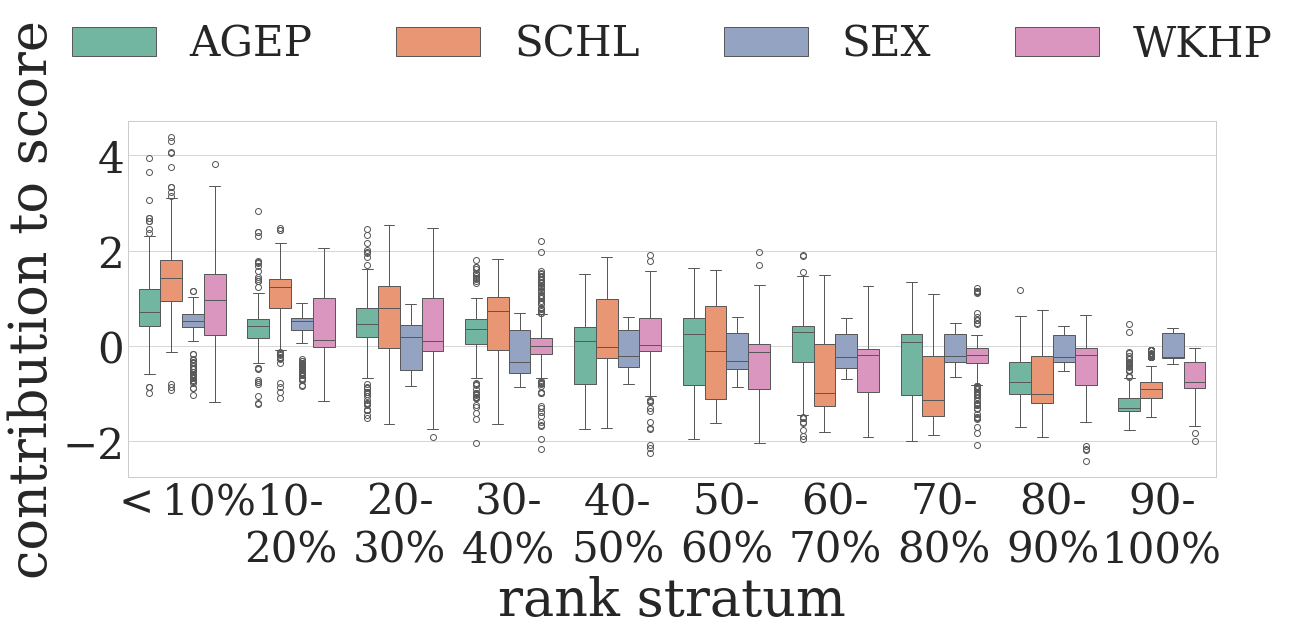

In [47]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

font = {
        'weight' : 'normal',
        'size'   : 42}

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
graph = sns.boxplot(
    x=shap_results['Rank Bucket'],
    y=shap_results['Contribution'],
    hue=shap_results['Feature'],
    palette="Set2"
)
graph.set_ylabel("contribution to score")
graph.set_xlabel("rank stratum")
sns.move_legend(
    graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
)

fig.savefig(
    f"ACSIncome_SHAP.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()